# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# # Here is a helping code that will download and unzip the dataset for you.
# # Once you download the dataset you may comment the code!
# !kaggle datasets download -d khaledzsa/traffic-dataset
# !unzip traffic-dataset.zip

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, LSTM, Dropout


In [3]:
df=pd.read_csv('Traffic Data.csv', parse_dates=['date_time'])
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [4]:
df.dtypes

traffic_volume                float64
temp                          float64
rain_1h                       float64
snow_1h                       float64
clouds_all                      int64
weather_main                   object
weather_description            object
date_time              datetime64[ns]
dtype: object

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

<Axes: title={'center': 'traffic_volume'}>

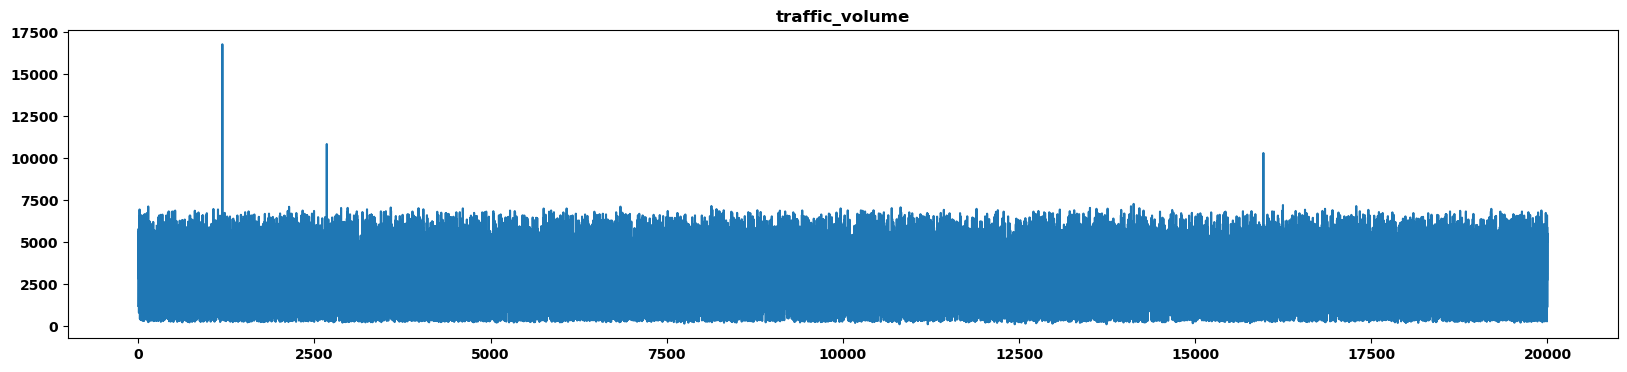

In [5]:
# Plot the time series data
df['traffic_volume'].plot(kind='line', figsize=(20, 4), title='traffic_volume')

<Axes: >

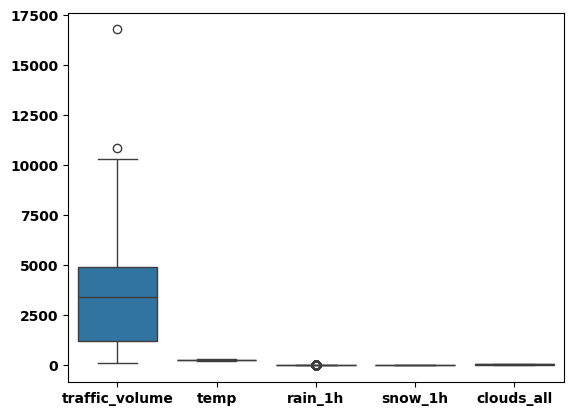

In [6]:
sns.boxplot(df)

 This function does not handle missing values, therfore I will perform it after cleaning

In [7]:
# # Decompose the time series data
# result = seasonal_decompose(df['traffic_volume'], model='additive', period=365)
# result.plot()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [8]:
# Handiling missing values
df.isnull().sum()

traffic_volume         20
temp                    0
rain_1h                 0
snow_1h                 0
clouds_all              0
weather_main            0
weather_description     0
date_time               0
dtype: int64

In [9]:
df=df.dropna()

In [10]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [11]:
#label encoding
le = LabelEncoder()
df['weather_main'] = le.fit_transform(df['weather_main'])
df['weather_description'] = le.fit_transform(df['weather_description'])

In [12]:
#set index 
df=df.set_index('date_time')

In [13]:
#Sort the dates
df = df.sort_index()
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,8,9
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,5,16
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,3,4
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,8,9
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,5,16


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [14]:
# Use the `shift` method to create a new column, represents the previous day's traffic volume
df['prev_traffic_volume']=df['traffic_volume'].shift(1)

<Axes: title={'center': 'prev_traffic_volume'}, xlabel='date_time'>

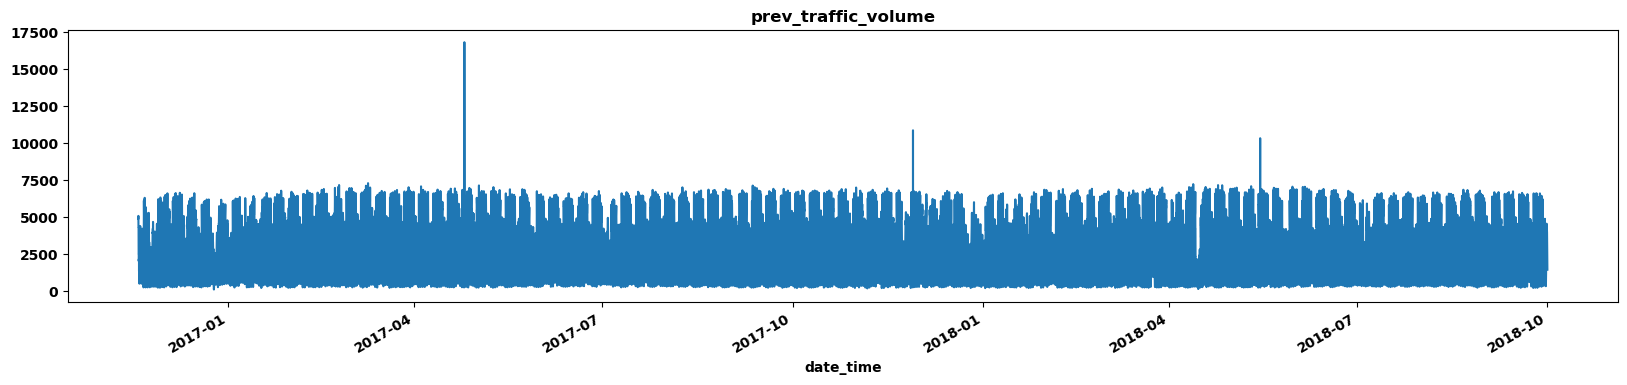

In [15]:
# plot the previous day's traffic volume
df['prev_traffic_volume'].plot(kind='line', figsize=(20, 4), title='prev_traffic_volume')

In [16]:
# Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.
df['diff_traffic_volume']=df['traffic_volume'].diff()

<Axes: title={'center': 'diff_traffic_volume'}, xlabel='date_time'>

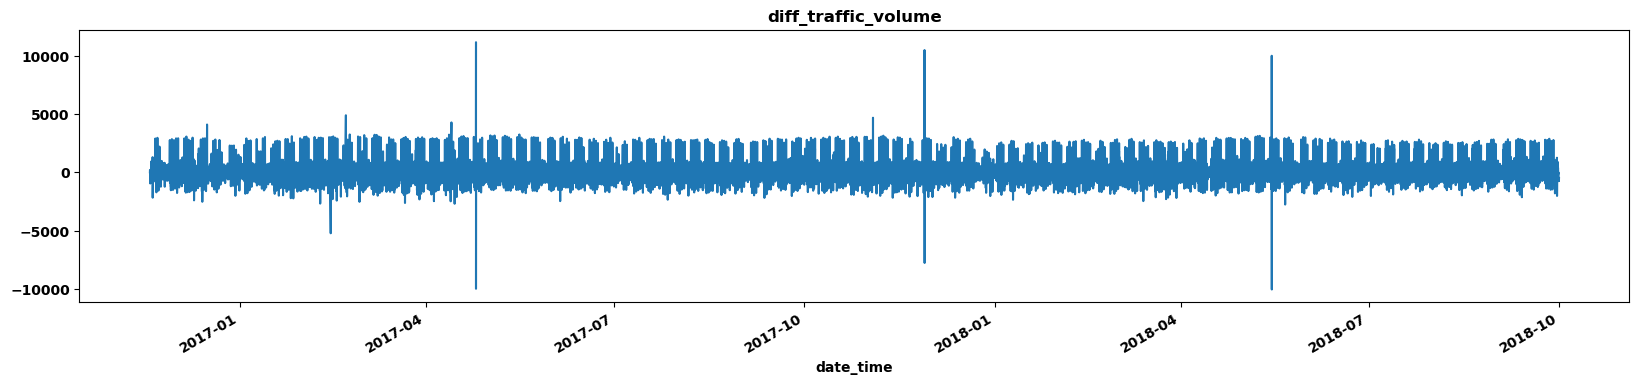

In [17]:
#plot the difference
df['diff_traffic_volume'].plot(kind='line', figsize=(20, 4), title='diff_traffic_volume')

In [18]:
# Extract meaningful time-based features from the `date_time` column
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek

In [19]:
df.dtypes

traffic_volume         float64
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main             int32
weather_description      int32
prev_traffic_volume    float64
diff_traffic_volume    float64
day_of_year              int32
month                    int32
day_of_week              int32
dtype: object

<Axes: ylabel='count'>

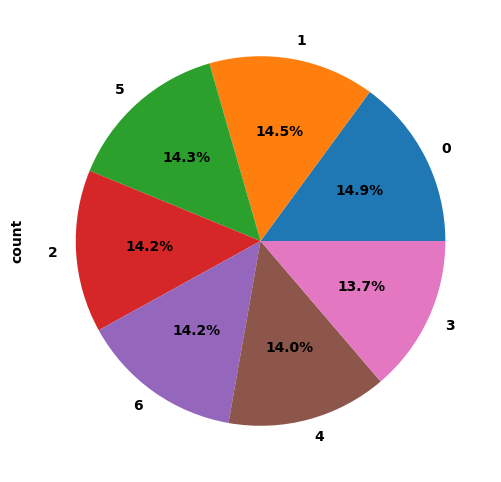

In [20]:
#pie chart of day of week
df['day_of_week'].value_counts().plot(kind='pie', figsize=(6, 6), autopct='%1.1f%%')

In [21]:
df.isnull().sum()

traffic_volume         0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
prev_traffic_volume    1
diff_traffic_volume    1
day_of_year            0
month                  0
day_of_week            0
dtype: int64

In [22]:
df.dropna(inplace=True)

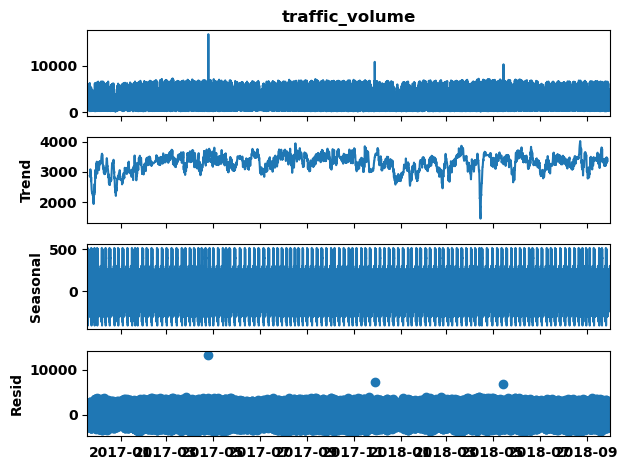

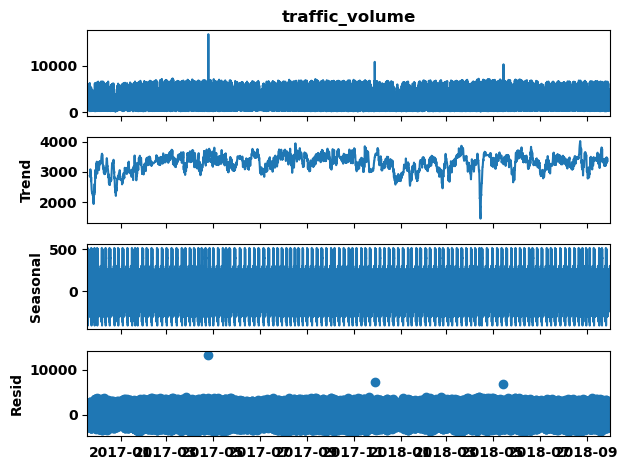

In [23]:
# Decompose the time series data
#Analyze trends, seasonality, and potential outliers.
result = seasonal_decompose(df['traffic_volume'], model='additive', period=24*7)
result.plot()

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [24]:
train_split = round(len(df) * 0.8)
train_data = df.iloc[:train_split]
test_data = df.iloc[train_split:]

In [25]:
train_data.shape, test_data.shape

((15983, 12), (3996, 12))

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.


In [26]:
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [27]:
# Prepare the data 
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0:dataset.shape[1]]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [28]:
X_train, y_train = create_dataset(train_data_scaled, 10)
X_test, y_test = create_dataset(test_data_scaled, 10)

In [29]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15972, 10, 12), (15972,), (3985, 10, 12), (3985,))

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [30]:
# GRU model
# Build the GRU model
model = Sequential()
model.add(GRU(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(units=16))
model.add(Dropout(0.2))
model.add(Dense(1))

c:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [31]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0245 - val_loss: 0.0125
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0036 - val_loss: 0.0094
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0024 - val_loss: 0.0073
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0021 - val_loss: 0.0084
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0020 - val_loss: 0.0058
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0019 - val_loss: 0.0065
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0018 - val_loss: 0.0051
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0016 - val_loss: 0.0039
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0017 - val_loss: 0.0031


### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [32]:
# Make predictions
predicted_traffic_volume = model.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [33]:
predicted_traffic_volume.shape

(3985, 1)

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [34]:
# Calculate MSE
mse = mean_squared_error(y_test, predicted_traffic_volume)

print(f"MSE: {mse:.4f}")

MSE: 0.0031


In [35]:
# Inverse transform to get actual traffic volume
predictions_rescaled = scaler.inverse_transform(np.concatenate((predicted_traffic_volume, np.zeros((predicted_traffic_volume.shape[0], 11))), axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 11))), axis=1))[:, 0]

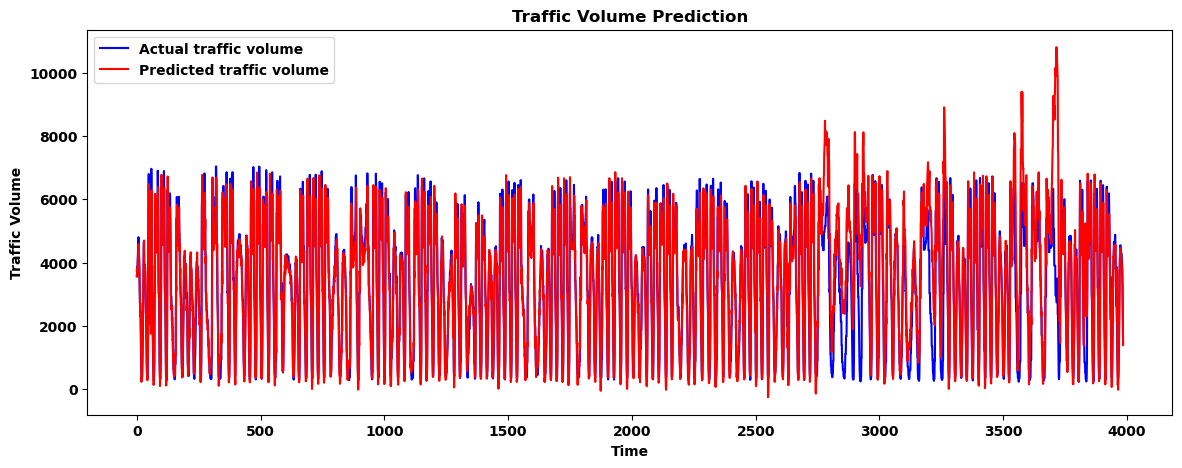

In [36]:
#plot the actual vs predicted traffic volume
plt.figure(figsize=(14, 5))
plt.plot(y_test_rescaled, color='blue', label='Actual traffic volume')
plt.plot(predictions_rescaled, color='red', label='Predicted traffic volume')
plt.title('Traffic Volume Prediction')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

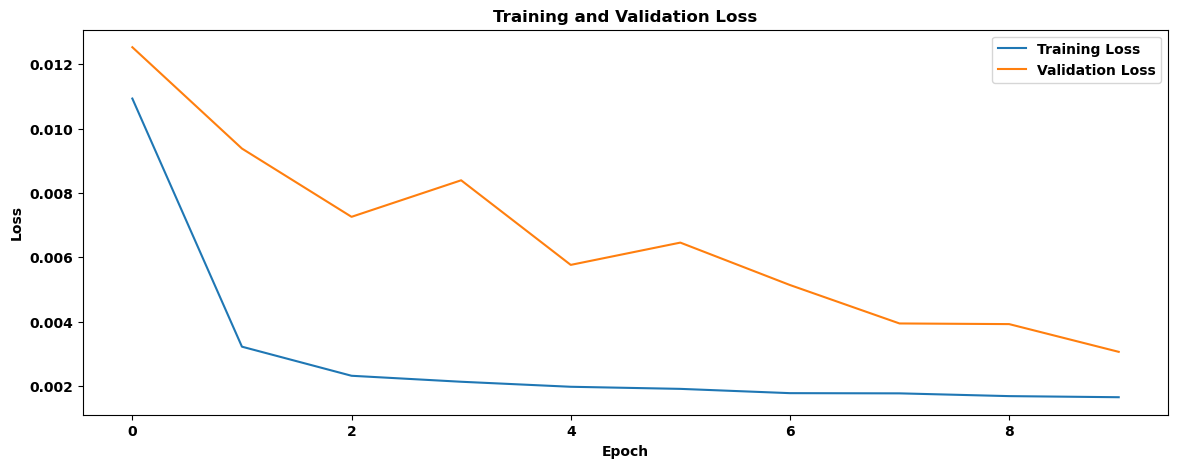

In [37]:
#plot the training and validation loss
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [38]:
# LSTM model
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(10, 12)))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,161 (125.63 KB)

 Trainable params: 32,161 (125.63 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Train the model
history_1 =model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0123 - val_loss: 0.0040
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0013 - val_loss: 0.0010


### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [41]:
# Make predictions
predicted_traffic_volume = model.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [42]:
# Calculate MSE
mse = mean_squared_error(y_test, predicted_traffic_volume)

print(f"MSE: {mse:.4f}")

MSE: 0.0010


In [43]:
# Inverse transform to get actual traffic volume
predictions_rescaled = scaler.inverse_transform(np.concatenate((predicted_traffic_volume, np.zeros((predicted_traffic_volume.shape[0], 11))), axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 11))), axis=1))[:, 0]

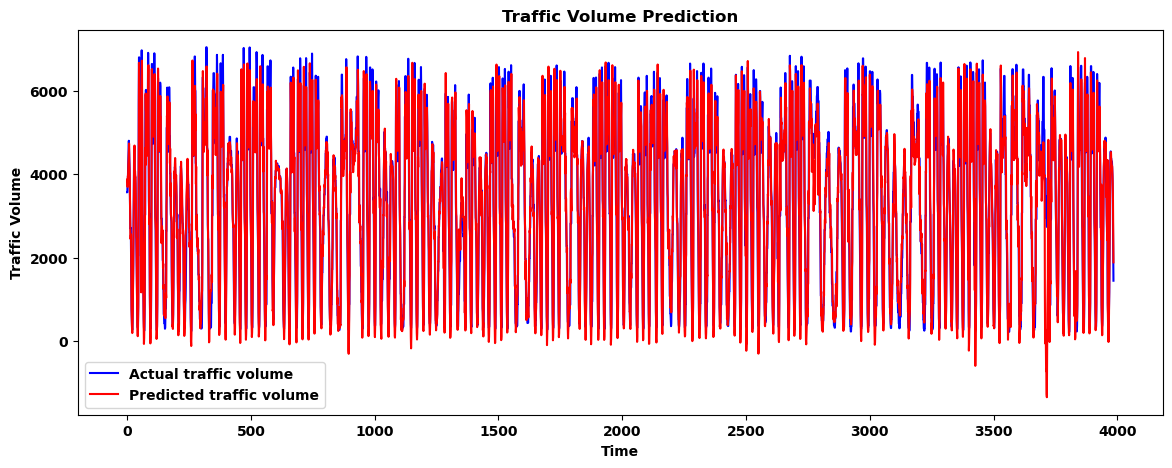

In [44]:
#plot the actual vs predicted traffic volume
plt.figure(figsize=(14, 5))
plt.plot(y_test_rescaled, color='blue', label='Actual traffic volume')
plt.plot(predictions_rescaled, color='red', label='Predicted traffic volume')
plt.title('Traffic Volume Prediction')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

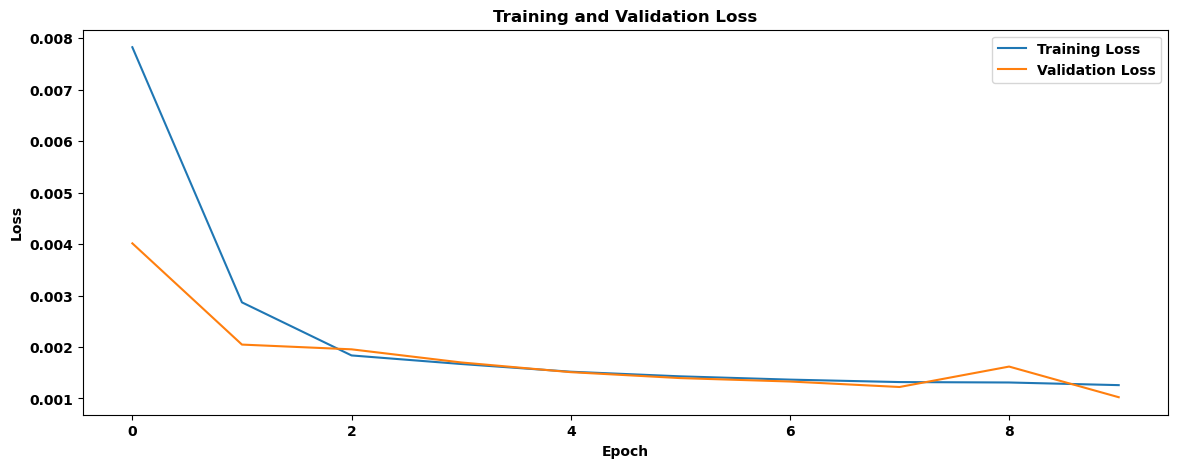

In [45]:
#plot the training and validation loss
plt.figure(figsize=(14, 5))
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:
- Data preprocessing:
1. Drop missing values since they were very low (22 instance) and only in one column traffic volume. 
2. Label encoder for categorical variables. 
3. Min-max scaling after splitting the data. 
4. Parsing the data and setting it as index. 
5. Visualize outliers in boxplot.
- Feature engineering: 
1. Shifting to represent the previous day's traffic volume and then visualize it in line plot. 
2. Calculate then visualize the difference between the traffic_volumeco to highlight short-term volume. 
3. Extract meaningful information from date_time column and visualizing day_of_week values in pie chart.
- Model architecture: Since it's a time series, I used LSTM and GRU, with dropout layer.The number of layer or neurons is chosen by doing a couple of experiments, then choosing the best performing one (Not the most efficient way, will explore different methods in the future).
- Training process: I did experiment with the batch size and other parameters and concluded that higher batch size actually performed worse , so I changed it from 64 to 32.
- Loss function and metrics: I used mean squared error (MSE) function 
- Model Tuning: As stated earlier expirements showed that having lower batch size and dropout layer minimized the resulted loss.
- Overfitting and Underfitting: Both mdoels don't appear to be overfitting nor underfitting by looking at the loss plot.
- Future Improvements: -